In [1]:
# --------------------
# 📌 1. Connexion à PostgreSQL
# --------------------
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# Configuration de connexion
USER = "postgres"
PASSWORD = "159753"
HOST = "localhost"
PORT = "5432"
DB = "SupplyChain_DW"

# Création de l'engine SQLAlchemy
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}')

In [2]:
query = """
SELECT 
    f."SupID_FK" AS Supplier_ID,
    f."id_MP_FK" AS MP_ID,
    f."Quantity",
    f."Delay_Days",
    f."Ware_ID_FK" AS Warehouse_ID,
    s."Average_Delai__days" AS Supplier_Avg_Delay,
    s."Supplier_Name",
    s."Delay_Cause",
    s."Day_of_Delay",
    mp."Price__USD_per_unit",
    mp."Product_Name",
    mp."Solubility"
FROM 
    "Fact_Procurment" f
JOIN 
    "Dim_Supplier" s ON f."SupID_FK" = s."SupID_PK"
JOIN 
    "DIM_MP" mp ON f."id_MP_FK" = mp."id_MP_PK"
"""

df = pd.read_sql_query(query, engine)
# Compute the difference
df['AvgDelay_DelayDiff'] = df['supplier_avg_delay'] - df['Delay_Days']

# Redefine IsLate based on the difference
df['IsLate'] = df['AvgDelay_DelayDiff'].apply(lambda x: 1 if x < 0 else 0)


# Aperçu
print(df.head())
df

   supplier_id  mp_id  Quantity  Delay_Days  warehouse_id  supplier_avg_delay  \
0            1      4        98          14             1                  15   
1            1     16        46          14             1                  15   
2            1     82         1          14             1                  15   
3            1    106        41          14             1                  15   
4            1    109        65          14             1                  15   

        Supplier_Name              Delay_Cause Day_of_Delay  \
0  Extraits Tunisiens  Retard douanier à Tunis   2024-10-19   
1  Extraits Tunisiens  Retard douanier à Tunis   2024-10-19   
2  Extraits Tunisiens  Retard douanier à Tunis   2024-10-19   
3  Extraits Tunisiens  Retard douanier à Tunis   2024-10-19   
4  Extraits Tunisiens  Retard douanier à Tunis   2024-10-19   

   Price__USD_per_unit          Product_Name     Solubility  \
0                67.07           Acacia Milk                  
1       

,supplier_id,mp_id,Quantity,Delay_Days,warehouse_id,supplier_avg_delay,Supplier_Name,Delay_Cause,Day_of_Delay,Price__USD_per_unit,Product_Name,Solubility,AvgDelay_DelayDiff,IsLate
0,1,4,98,14,1,15,Extraits Tunisiens,Retard douanier à Tunis,2024-10-19,67.07,Acacia Milk,,1,0
1,1,16,46,14,1,15,Extraits Tunisiens,Retard douanier à Tunis,2024-10-19,403.64,AHA Fruit Acid Blend,Water-soluble,1,0
2,1,82,1,14,1,15,Extraits Tunisiens,Retard douanier à Tunis,2024-10-19,315.70,Banana Extract,Water-soluble,1,0
3,1,106,41,14,1,15,Extraits Tunisiens,Retard douanier à Tunis,2024-10-19,228.41,Birch Leaf Extract,Water-soluble,1,0
4,1,109,65,14,1,15,Extraits Tunisiens,Retard douanier à Tunis,2024-10-19,339.47,Black Cohosh Extract,Water-soluble,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16540,161,1077,46,17,1,17,Extraits de Cèdre,Délais paiement client,2025-06-10,59.60,Wheat Germ Extract,Water-soluble,0,0
16541,161,1083,83,17,1,17,Extraits de Cèdre,Délais paiement client,2025-06-10,202.20,Wild Cherry Bark Extract,Water-soluble,0,0
16542,161,1095,3,17,1,17,Extraits de Cèdre,Délais paiement client,2025-06-10,457.24,Yellow Dock Extract,Water-soluble,0,0
16543,161,1100,34,17,1,17,Extraits de Cèdre,Délais paiement client,2025-06-10,78.65,"Zinc Oxide, Micronized",Insoluble but dispersible in water and oils,0,0


## Objective 1: Unsupervised Learning (Clustering)

# KMeans

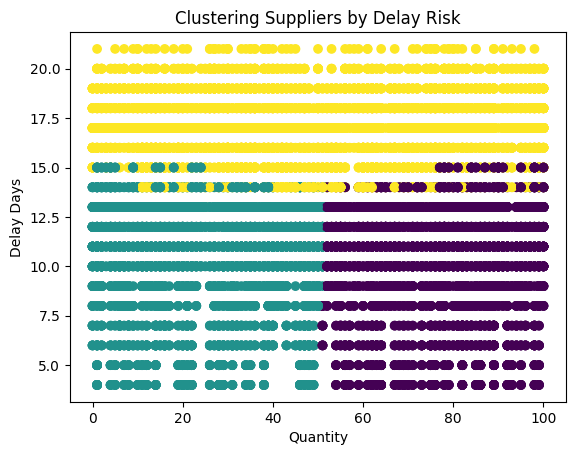


Cluster Summary:
          Quantity  Delay_Days  supplier_avg_delay
Cluster                                           
0        76.738202   10.237126            9.999021
1        25.929321   10.312611           10.086716
2        49.903554   17.050415           16.771098


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Features for clustering
features_clust = df[['Quantity', 'Delay_Days', 'supplier_avg_delay']].fillna(0)
X_clust = StandardScaler().fit_transform(features_clust)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_clust)

# Visualize the clusters
plt.scatter(df['Quantity'], df['Delay_Days'], c=df['Cluster'], cmap='viridis')
plt.xlabel("Quantity")
plt.ylabel("Delay Days")
plt.title("Clustering Suppliers by Delay Risk")
plt.show()

# Analyze clusters
cluster_summary = df.groupby('Cluster')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean()
print("\nCluster Summary:")
print(cluster_summary)

# GaussianMixture

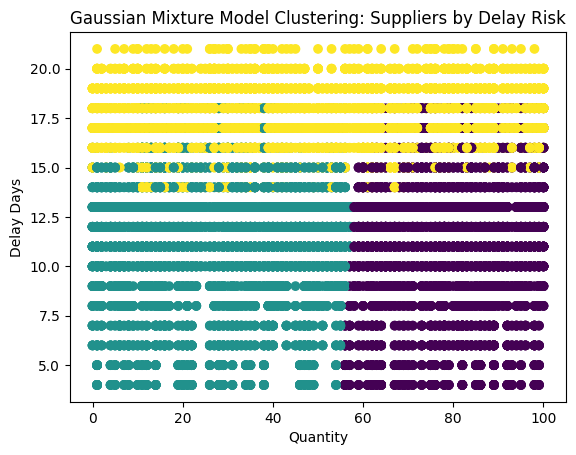


Gaussian Mixture Model Clustering Summary:
              Quantity  Delay_Days  supplier_avg_delay
Cluster_GMM                                           
0            79.004415   11.001288           10.763613
1            28.695566   11.145665           10.881914
2            49.231852   17.668060           17.422129


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Features for clustering (unchanged)
features_clust = df[['Quantity', 'Delay_Days', 'supplier_avg_delay']].fillna(0)
X_clust = StandardScaler().fit_transform(features_clust)

# Apply Gaussian Mixture Model (3 components to match KMeans)
gmm = GaussianMixture(n_components=3, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(X_clust)

# Visualize the clusters
plt.scatter(df['Quantity'], df['Delay_Days'], c=df['Cluster_GMM'], cmap='viridis')
plt.xlabel("Quantity")
plt.ylabel("Delay Days")
plt.title("Gaussian Mixture Model Clustering: Suppliers by Delay Risk")
plt.show()

# Analyze clusters
cluster_summary_gmm = df.groupby('Cluster_GMM')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean()
print("\nGaussian Mixture Model Clustering Summary:")
print(cluster_summary_gmm)

# DBSCAN

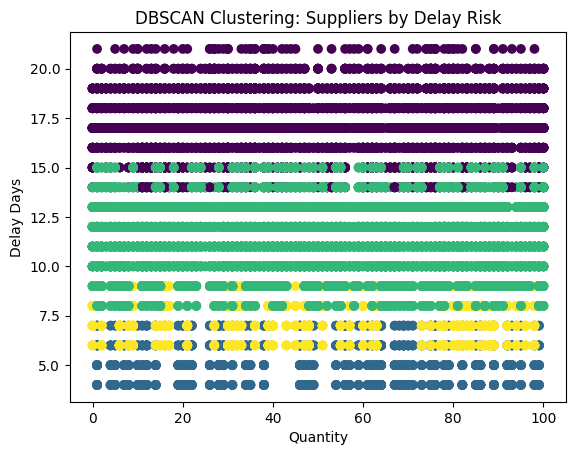


DBSCAN Clustering Summary (Excluding Noise):
                 Quantity  Delay_Days  supplier_avg_delay
Cluster_DBSCAN                                           
0               49.796209   17.033333           16.848341
1               51.328947    5.266667            5.000000
2               51.500000   11.442040           11.136194
3               52.000000    7.200000            7.000000

Number of Outliers (Noise Points): 0


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Features for clustering (unchanged)
features_clust = df[['Quantity', 'Delay_Days', 'supplier_avg_delay']].fillna(0)
X_clust = StandardScaler().fit_transform(features_clust)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_clust)

# Visualize the clusters (Cluster_DBSCAN == -1 indicates noise/outliers)
plt.scatter(df['Quantity'], df['Delay_Days'], c=df['Cluster_DBSCAN'], cmap='viridis')
plt.xlabel("Quantity")
plt.ylabel("Delay Days")
plt.title("DBSCAN Clustering: Suppliers by Delay Risk")
plt.show()

# Analyze clusters (excluding noise points, i.e., Cluster_DBSCAN != -1)
cluster_summary_dbscan = df[df['Cluster_DBSCAN'] != -1].groupby('Cluster_DBSCAN')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean()
print("\nDBSCAN Clustering Summary (Excluding Noise):")
print(cluster_summary_dbscan)

# Count outliers
num_outliers = len(df[df['Cluster_DBSCAN'] == -1])
print(f"\nNumber of Outliers (Noise Points): {num_outliers}")

# CAH

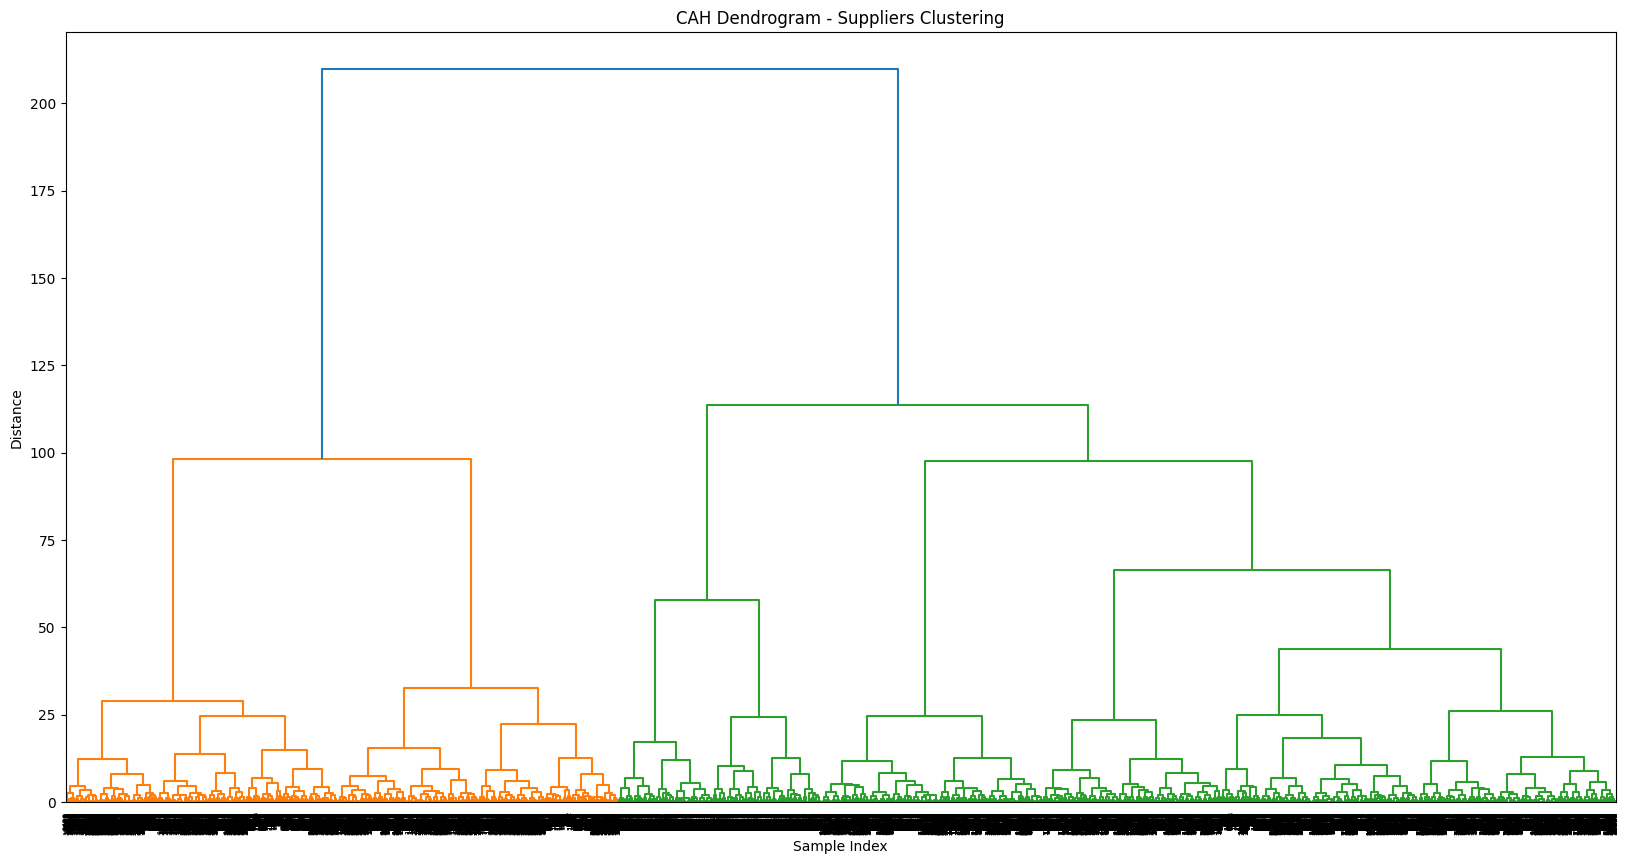

In [6]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import seaborn as sns

# We'll use the same features
features_cah = df[['Quantity', 'Delay_Days', 'supplier_avg_delay']].fillna(0)
X_cah = StandardScaler().fit_transform(features_cah)

# Calculate the linkage matrix
linked = sch.linkage(X_cah, method='ward')  # 'ward' minimizes variance within clusters

# Plot dendrogram
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(linked)
plt.title("CAH Dendrogram - Suppliers Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


In [9]:
import pandas as pd
from IPython.display import display, Markdown

# Display clustering summaries
summary = {
    'Cluster_KMeans': df.groupby('Cluster_KMeans')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean().round(2),
    'Cluster_DBSCAN': df.groupby('Cluster_DBSCAN')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean().round(2),
    'Cluster_GMM': df.groupby('Cluster_GMM')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean().round(2),
    'Cluster_CAH': df.groupby('Cluster_CAH')[['Quantity', 'Delay_Days', 'supplier_avg_delay']].mean().round(2),
}

# Display each table with a title
for name, table in summary.items():
    display(Markdown(f"### {name.replace('_', ' ')}"))
    display(table)

### Cluster KMeans

,Quantity,Delay_Days,supplier_avg_delay
Cluster_KMeans,,,
0,76.74,10.24,10.00
1,25.93,10.31,10.09
2,49.90,17.05,16.77


### Cluster DBSCAN

,Quantity,Delay_Days,supplier_avg_delay
Cluster_DBSCAN,,,
0,50.87,12.89,12.64


### Cluster GMM

,Quantity,Delay_Days,supplier_avg_delay
Cluster_GMM,,,
0,79.00,11.00,10.76
1,28.70,11.15,10.88
2,49.23,17.67,17.42


### Cluster CAH

,Quantity,Delay_Days,supplier_avg_delay
Cluster_CAH,,,
0,50.11,17.23,16.95
1,51.19,11.58,11.35
2,51.65,6.19,5.95


In [10]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores (except DBSCAN if too many noise points)
scores = {
    'KMeans': silhouette_score(X, df['Cluster_KMeans']),
    'GMM': silhouette_score(X, df['Cluster_GMM']),
    'CAH': silhouette_score(X, df['Cluster_CAH'])
}

# Only include DBSCAN if there are multiple valid clusters
dbscan_labels = df['Cluster_DBSCAN']
if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
    try:
        scores['DBSCAN'] = silhouette_score(X, dbscan_labels)
    except:
        scores['DBSCAN'] = "N/A (too many noise points)"
else:
    scores['DBSCAN'] = "N/A (only one cluster)"

print("Silhouette Scores:")
for method, score in scores.items():
    print(f"{method}: {score}")


Silhouette Scores:
KMeans: 0.3918631482345746
GMM: 0.3266397644661481
CAH: 0.3577060626526323
DBSCAN: N/A (only one cluster)


## Objective 2: Supervised Classification (Predicting Delivery Delays)

# RandomForestClassifier

Class distribution in y_train: IsLate
0    7556
1    5680
Name: count, dtype: int64
Class distribution in y_test: IsLate
0    1928
1    1381
Name: count, dtype: int64

📊 Classification Report (Predicting Delivery Delays):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1928
           1       1.00      1.00      1.00      1381

    accuracy                           1.00      3309
   macro avg       1.00      1.00      1.00      3309
weighted avg       1.00      1.00      1.00      3309


Feature Importance:
               Feature  Importance
3  DELAY_CAUSE_Encoded    0.767661
1   supplier_avg_delay    0.170976
2  Price__USD_per_unit    0.034281
0             Quantity    0.027083


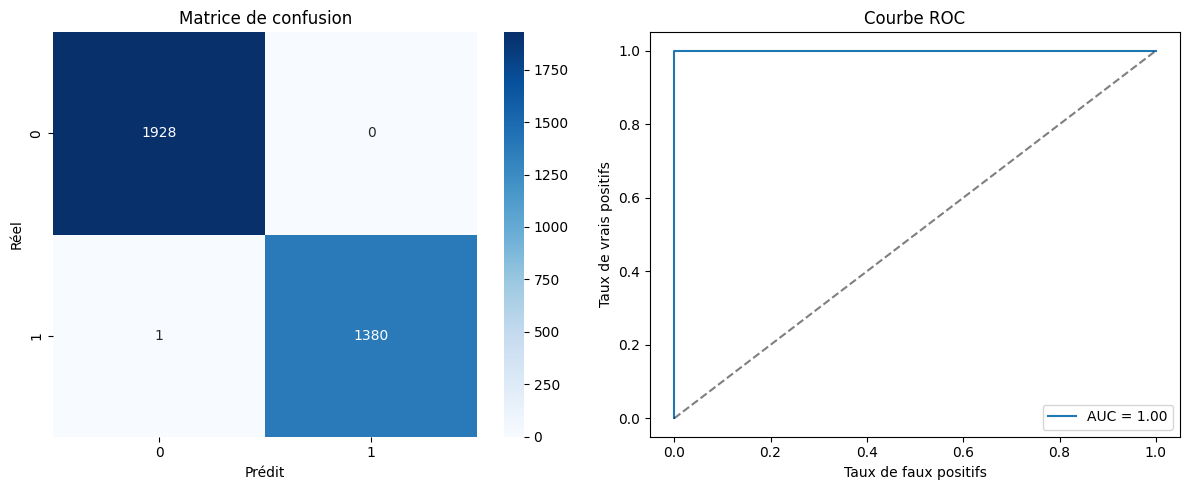

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Encode categorical features
le_delay_cause = LabelEncoder()
df['DELAY_CAUSE_Encoded'] = le_delay_cause.fit_transform(df['Delay_Cause'].fillna('Unknown'))

# Features and target
features_class = df[['Quantity', 'supplier_avg_delay', 'Price__USD_per_unit', 'DELAY_CAUSE_Encoded']].fillna(0)
target_class = df['IsLate']


# Split data
X_train, X_test, y_train, y_test = train_test_split(features_class, target_class, test_size=0.2, random_state=42)
print("Class distribution in y_train:", y_train.value_counts())
print("Class distribution in y_test:", y_test.value_counts())

# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n📊 Classification Report (Predicting Delivery Delays):")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'Feature': features_class.columns, 'Importance': clf.feature_importances_})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Affichage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# LogisticRegression


📊 Classification Report (Logistic Regression - Predicting Delivery Delays):
              precision    recall  f1-score   support

           0       0.58      1.00      0.74      1928
           1       0.00      0.00      0.00      1381

    accuracy                           0.58      3309
   macro avg       0.29      0.50      0.37      3309
weighted avg       0.34      0.58      0.43      3309


Feature Coefficients (Logistic Regression):
               Feature  Coefficient
0             Quantity     0.000507
2  Price__USD_per_unit    -0.000064
1   supplier_avg_delay    -0.002386
3  DELAY_CAUSE_Encoded    -0.002577


C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

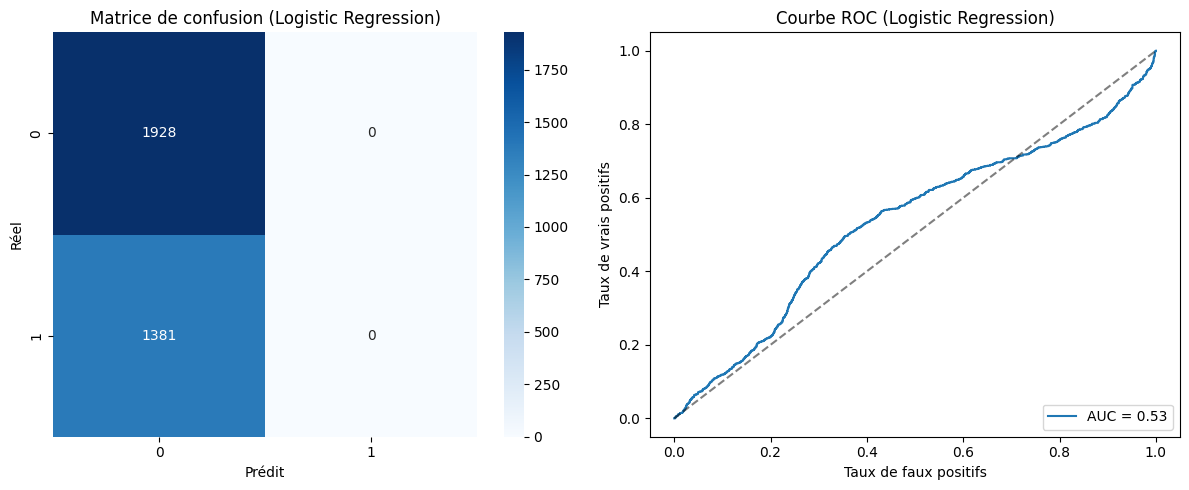

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Encode categorical features (unchanged)
le_delay_cause = LabelEncoder()
df['DELAY_CAUSE_Encoded'] = le_delay_cause.fit_transform(df['Delay_Cause'].fillna('Unknown'))

# Features and target (unchanged)
features_class = df[['Quantity', 'supplier_avg_delay', 'Price__USD_per_unit', 'DELAY_CAUSE_Encoded']].fillna(0)
target_class = df['IsLate']

# Split data (unchanged)
X_train, X_test, y_train, y_test = train_test_split(features_class, target_class, test_size=0.2, random_state=42)

# Train LogisticRegression
clf_lr = LogisticRegression(random_state=42, max_iter=1000)  # max_iter increased to ensure convergence
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_proba_lr = clf_lr.predict_proba(X_test)[:, 1]

# Evaluate
print("\n📊 Classification Report (Logistic Regression - Predicting Delivery Delays):")
print(classification_report(y_test, y_pred_lr))

# Feature importance (using coefficients for Logistic Regression)
feature_importance_lr = pd.DataFrame({'Feature': features_class.columns, 'Coefficient': clf_lr.coef_[0]})
print("\nFeature Coefficients (Logistic Regression):")
print(feature_importance_lr.sort_values(by='Coefficient', ascending=False))

# Matrice de confusion
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Affichage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (Logistic Regression)")
plt.xlabel("Prédit")
plt.ylabel("Réel")

plt.subplot(1, 2, 2)
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {roc_auc_lr:.2f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC (Logistic Regression)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# SVC rbf

New class distribution of IsLate: IsLate
0    9484
1    7061
Name: count, dtype: int64
Class distribution in y_train: IsLate
0    7587
1    5649
Name: count, dtype: int64
Class distribution in y_test: IsLate
0    1897
1    1412
Name: count, dtype: int64
✅ Scaler and LabelEncoder saved successfully!

📊 Classification Report (SVC with RBF Kernel - Predicting Delivery Delays):
              precision    recall  f1-score   support

           0       0.67      0.54      0.60      1897
           1       0.51      0.65      0.57      1412

    accuracy                           0.59      3309
   macro avg       0.59      0.59      0.59      3309
weighted avg       0.60      0.59      0.59      3309

Accuracy (SVC with RBF Kernel): 0.5860

Cross-Validation F1-Macro Scores: [0.6011757  0.60083169 0.61570716 0.60281291 0.58628423]
Mean CV F1-Macro: 0.6014, Std: 0.0093


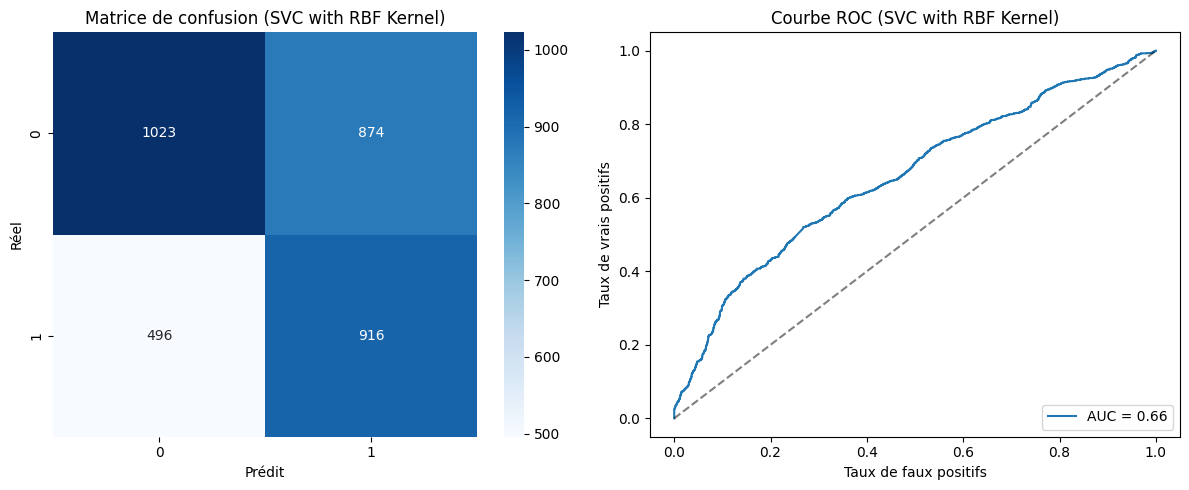

In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import os
from sklearn.svm import SVC  # Use SVC instead of LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Assuming df is already loaded with the necessary columns
# If not, you would load your dataset here, e.g.:
# df = pd.read_csv('your_dataset.csv')

# Encode categorical features
le_delay_cause = LabelEncoder()
df['DELAY_CAUSE_Encoded'] = le_delay_cause.fit_transform(df['Delay_Cause'].fillna('Unknown'))


# Check the new class distribution
print("New class distribution of IsLate:", df['IsLate'].value_counts())

# Features and target (exclude AvgDelay_DelayDiff and Delay_Days)
features_class = df[['Quantity', 'supplier_avg_delay', 'Price__USD_per_unit', 'DELAY_CAUSE_Encoded']].fillna(0)
target_class = df['IsLate']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    features_class, 
    target_class, 
    test_size=0.2, 
    random_state=42, 
    stratify=target_class
)

# Check class distribution in train and test sets
print("Class distribution in y_train:", y_train.value_counts())
print("Class distribution in y_test:", y_test.value_counts())

# Scale the features (required for SVC with RBF kernel)
scaler = StandardScaler()

scaler.fit(features_class)  # Fit on training features

# Define current directory


# Save both pre-processing objects
scaler_path = os.path.join( 'scaler.pkl')
encoder_path = os.path.join ('label_encoder_delay_cause.pkl')

joblib.dump(scaler, scaler_path)
joblib.dump(le_delay_cause, encoder_path)

print("✅ Scaler and LabelEncoder saved successfully!")

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVC with RBF kernel
clf_svc = SVC(
    kernel='rbf',  # Use RBF kernel for non-linear relationships
    C=1.0,  # Regularization parameter
    class_weight='balanced',  # Handle class imbalance
    probability=True,  # Enable predict_proba (note: this slows down training)
    random_state=42
) # fine tunning 
clf_svc.fit(X_train_scaled, y_train)

# Predictions
y_pred_svc = clf_svc.predict(X_test_scaled)
y_proba_svc = clf_svc.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\n📊 Classification Report (SVC with RBF Kernel - Predicting Delivery Delays):")
print(classification_report(y_test, y_pred_svc))

# Compute accuracy separately
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy (SVC with RBF Kernel): {accuracy_svc:.4f}")

# Cross-validation to check generalization
cv_scores = cross_val_score(clf_svc, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"\nCross-Validation F1-Macro Scores: {cv_scores}")
print(f"Mean CV F1-Macro: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)

# ROC curve
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_proba_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plotting
plt.figure(figsize=(12, 5))

# Confusion matrix plot
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion (SVC with RBF Kernel)")
plt.xlabel("Prédit")
plt.ylabel("Réel")

# ROC curve plot
plt.subplot(1, 2, 2)
plt.plot(fpr_svc, tpr_svc, label=f"AUC = {roc_auc_svc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC (SVC with RBF Kernel)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best Parameters from Grid Search:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

📊 Classification Report (Fine-Tuned SVC):
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1897
           1       0.65      0.74      0.69      1412

    accuracy                           0.72      3309
   macro avg       0.72      0.72      0.72      3309
weighted avg       0.73      0.72      0.72      3309

Accuracy (Fine-Tuned SVC): 0.7193


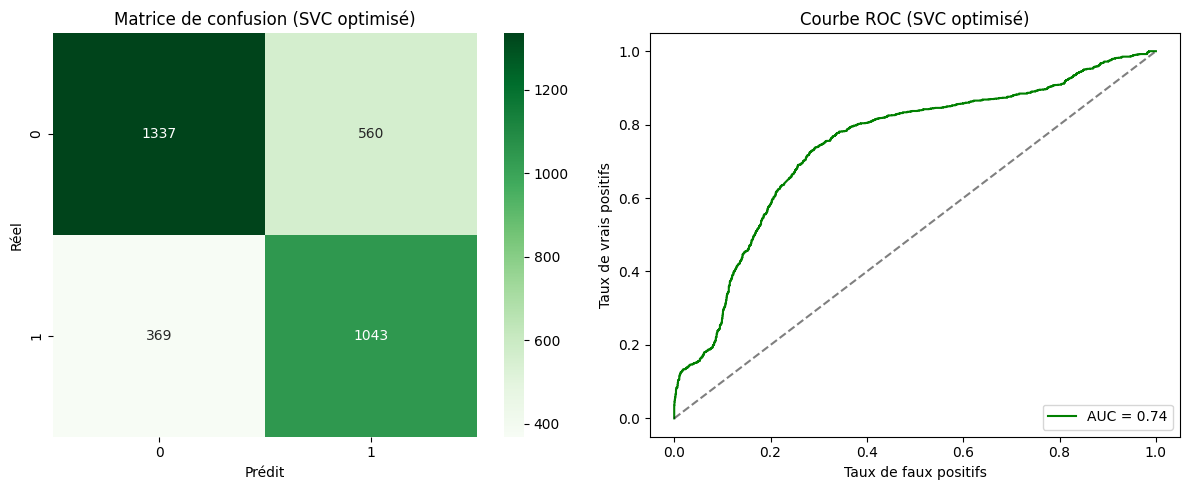

In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for fine-tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'gamma': [0.01, 0.1, 1, 'scale'],  # Kernel coefficient
    'kernel': ['rbf']  # Already using RBF kernel
    
}

# Set up GridSearchCV with your current settings
grid_search = GridSearchCV(
    estimator=SVC(probability=True, class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on your training data
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model and print the best parameters
best_svc = grid_search.best_estimator_
print("\n✅ Best Parameters from Grid Search:")
print(grid_search.best_params_)

# Use the best model to predict
y_pred_best = best_svc.predict(X_test_scaled)
y_proba_best = best_svc.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\n📊 Classification Report (Fine-Tuned SVC):")
print(classification_report(y_test, y_pred_best))
print(f"Accuracy (Fine-Tuned SVC): {accuracy_score(y_test, y_pred_best):.4f}")

# ROC & Confusion Matrix
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Plot results
plt.figure(figsize=(12, 5))

# Confusion matrix plot
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion (SVC optimisé)")
plt.xlabel("Prédit")
plt.ylabel("Réel")

# ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr_best, tpr_best, label=f"AUC = {roc_auc_best:.2f}", color='green')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC (SVC optimisé)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Scale features for SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add SVC to models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVC (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42)
}

# Store results
results = []

for name, model in models.items():
    if "SVC" in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 3),
        'Precision (On Time)': round(report['0']['precision'], 3),
        'Recall (On Time)': round(report['0']['recall'], 3),
        'F1-score (On Time)': round(report['0']['f1-score'], 3),
        'Precision (Delayed)': round(report['1']['precision'], 3),
        'Recall (Delayed)': round(report['1']['recall'], 3),
        'F1-score (Delayed)': round(report['1']['f1-score'], 3)
    })

# Display comparison table
summary_df = pd.DataFrame(results)
summary_df.set_index('Model', inplace=True)
display(summary_df)


C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

,Accuracy,Precision (On Time),Recall (On Time),F1-score (On Time),Precision (Delayed),Recall (Delayed),F1-score (Delayed)
Model,,,,,,,
Random Forest,1.000,0.999,1.000,1.000,1.000,0.999,1.000
Logistic Regression,0.583,0.583,1.000,0.736,0.000,0.000,0.000
SVC (RBF Kernel),0.661,0.664,0.846,0.744,0.652,0.403,0.498


In [10]:
import joblib

# Save the best model
joblib.dump(best_svc, 'fine_tuned_svc_model.pkl')
print("✅ Model saved as fine_tuned_svc_model.pkl")


✅ Model saved as fine_tuned_svc_model.pkl


## Objective 3: Supervised Regression (Predicting Delay Days)

# GradientBoostingRegressor


📊 Regression Error (GradientBoostingRegressor - Predicting Delay Days):
MAE: 0.4909132257456505
MSE: 0.3823875803789542
RMSE: 0.6183749512868015
R²: 0.976526418259259


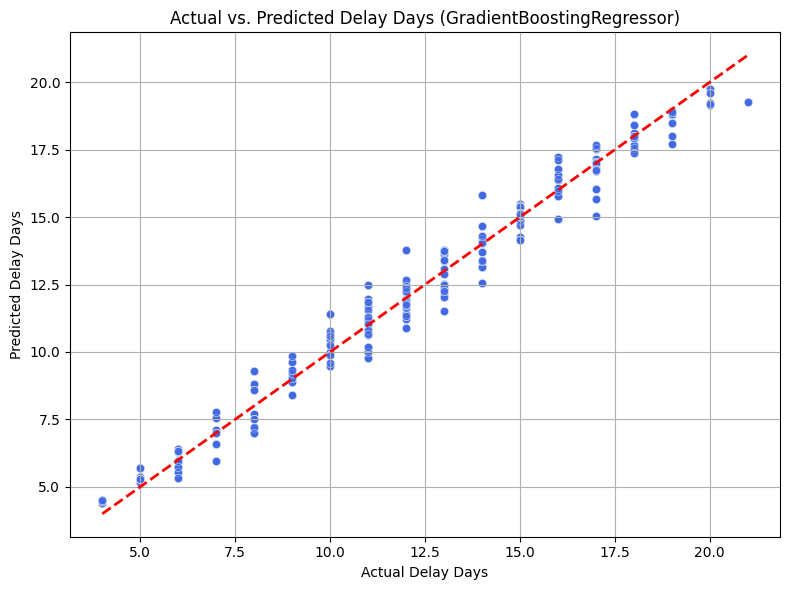

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

# Features and target
features_reg = df[['Quantity', 'supplier_avg_delay', 'Price__USD_per_unit', 'DELAY_CAUSE_Encoded']].fillna(0)
target_reg = df['Delay_Days'].fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(features_reg, target_reg, test_size=0.2, random_state=42)

# Train GradientBoostingRegressor
reg_gb = GradientBoostingRegressor(random_state=42)
reg_gb.fit(X_train, y_train)
y_pred_gb = reg_gb.predict(X_test)

# Evaluate GradientBoostingRegressor
print("\n📊 Regression Error (GradientBoostingRegressor - Predicting Delay Days):")
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("MAE:", mae_gb)
print("MSE:", mse_gb)
print("RMSE:", rmse_gb)
print("R²:", r2_gb)

# Plot actual vs. predicted for GradientBoostingRegressor
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_gb, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Delay Days")
plt.ylabel("Predicted Delay Days")
plt.title("Actual vs. Predicted Delay Days (GradientBoostingRegressor)")
plt.grid(True)
plt.tight_layout()
plt.show()

This model performs the best across all metrics. It has the lowest errors (MAE, MSE, RMSE) and the highest R², indicating it explains 97.65% of the variance in Delay_Days. The RMSE of 0.618375 means the average prediction error is about 0.62 days, which is quite good.

# LinearRegression


📊 Regression Error (LinearRegression - Predicting Delay Days):
MAE: 0.9983481797789441
MSE: 1.429319356708179
RMSE: 1.1955414491803198
R²: 0.9122585395685111


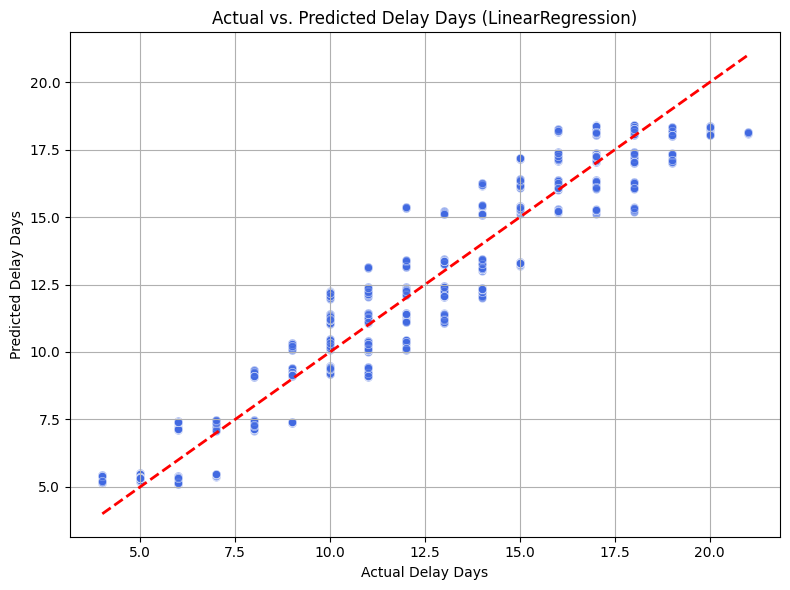

In [12]:
from sklearn.linear_model import LinearRegression
# Train LinearRegression
reg_lr = LinearRegression()
reg_lr.fit(X_train, y_train)
y_pred_lr = reg_lr.predict(X_test)

# Evaluate LinearRegression
print("\n📊 Regression Error (LinearRegression - Predicting Delay Days):")
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("MAE:", mae_lr)
print("MSE:", mse_lr)
print("RMSE:", rmse_lr)
print("R²:", r2_lr)

# Plot actual vs. predicted for LinearRegression
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Delay Days")
plt.ylabel("Predicted Delay Days")
plt.title("Actual vs. Predicted Delay Days (LinearRegression)")
plt.grid(True)
plt.tight_layout()
plt.show()

This model performs the worst. It has the highest errors and the lowest R² (91.23%), suggesting it struggles to capture the relationship between the features and Delay_Days. This is likely because the relationship is non-linear, and LinearRegression assumes a linear relationship.

# RandomForestRegressor


📊 Regression Error (RandomForestRegressor - Predicting Delay Days):
MAE: 0.7900835343111134
MSE: 0.9545431183202109
RMSE: 0.9770072253162773
R²: 0.9414035730691203


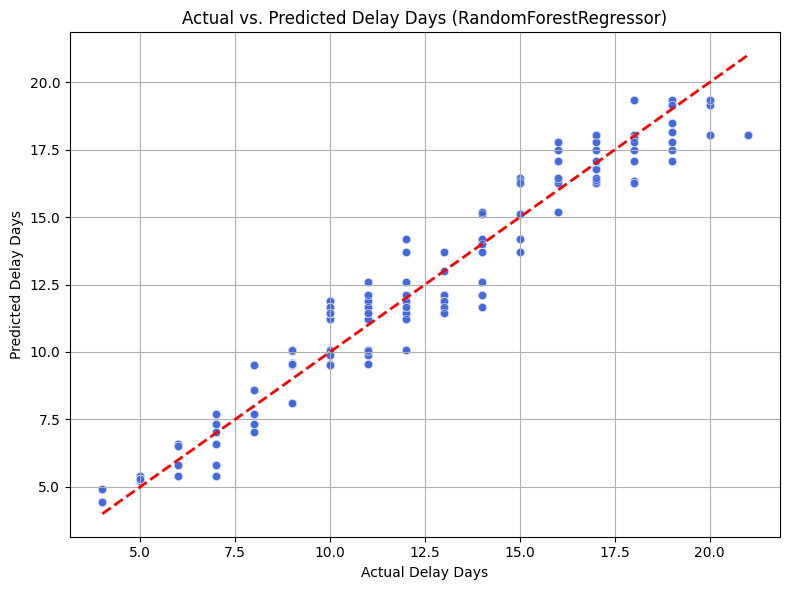

In [13]:
from sklearn.ensemble import  RandomForestRegressor
# Train RandomForestRegressor
reg_rf = RandomForestRegressor(
    random_state=42,
    max_depth=5,  # Limit depth to prevent overfitting
    n_estimators=50,  # Fewer trees for faster training
    min_samples_leaf=10  # Increase leaf size to prevent overfitting
)
reg_rf.fit(X_train, y_train)
y_pred_rf = reg_rf.predict(X_test)

# Evaluate RandomForestRegressor
print("\n📊 Regression Error (RandomForestRegressor - Predicting Delay Days):")
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("R²:", r2_rf)

# Plot actual vs. predicted for RandomForestRegressor
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Delay Days")
plt.ylabel("Predicted Delay Days")
plt.title("Actual vs. Predicted Delay Days (RandomForestRegressor)")
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretation: This model performs better than LinearRegression but worse than GradientBoostingRegressor. It explains 94.14% of the variance (R²), and its RMSE of 0.977007 means the average prediction error is about 0.98 days. The performance is decent but not as good as GradientBoostingRegressor.


📊 Comparison of Regression Models:
                                MAE       MSE      RMSE        R²
GradientBoostingRegressor  0.490913  0.382388  0.618375  0.976526
LinearRegression           0.998348  1.429319  1.195541  0.912259
RandomForestRegressor      0.790084  0.954543  0.977007  0.941404


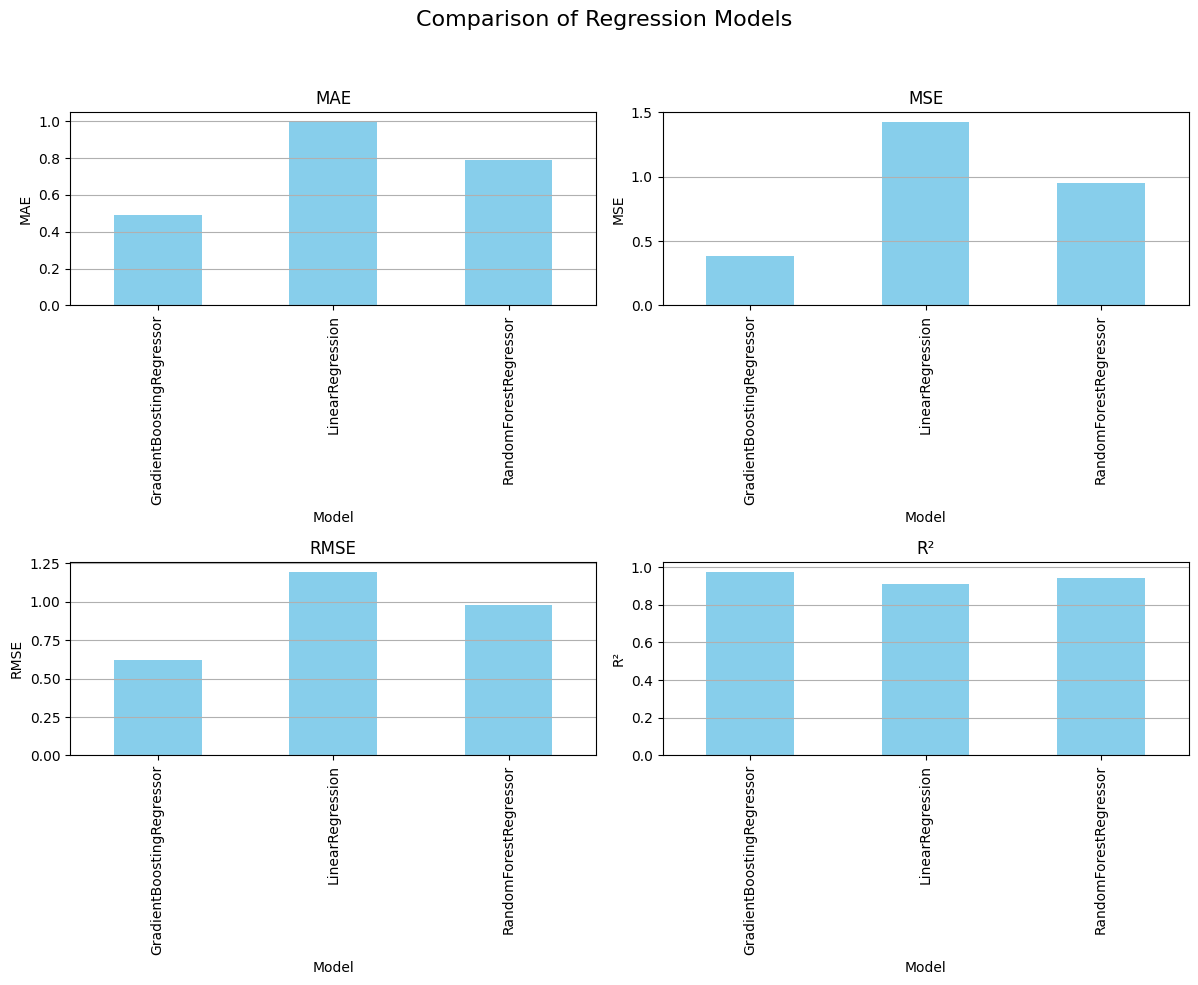

In [30]:
# Create a comparison table
results = {
    "GradientBoostingRegressor": {"MAE": mae_gb, "MSE": mse_gb, "RMSE": rmse_gb, "R²": r2_gb},
    "LinearRegression": {"MAE": mae_lr, "MSE": mse_lr, "RMSE": rmse_lr, "R²": r2_lr},
    "RandomForestRegressor": {"MAE": mae_rf, "MSE": mse_rf, "RMSE": rmse_rf, "R²": r2_rf}
}
print("\n📊 Comparison of Regression Models:")
comparison_df = pd.DataFrame(results).T
print(comparison_df)

# Plot a bar chart to compare the metrics
metrics = ["MAE", "MSE", "RMSE", "R²"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparison of Regression Models", fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    comparison_df[metric].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")
    ax.grid(True, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
import joblib
import os

# Save model
model_path = os.path.join(os.getcwd(), 'randomforest.pkl')
joblib.dump(reg_rf, model_path)
print(f"✅ Model saved at: {model_path}")

✅ Model saved at: c:\Users\moham\OneDrive\Bureau\Cosmetic_Supply_Chain_Machine_Learning\randomforest.pkl


## Objective 4: Alternative for Time Series (Predicting Material Shortages)

# Prophet

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Simulated time series data
dates = pd.date_range(start='2023-01-01', periods=24, freq='MS')
avg_delay_per_month = np.random.normal(loc=3, scale=2, size=24).clip(min=0)

ts_df = pd.DataFrame({
    'ds': dates,
    'y': avg_delay_per_month
})

# For ARIMA and SARIMA, we need the time series as a pandas Series with a datetime index
ts_series = pd.Series(avg_delay_per_month, index=dates)
# Future dates for forecasting (6 months)
future_dates = pd.date_range(start='2025-01-01', periods=6, freq='MS')

22:31:16 - cmdstanpy - INFO - Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing


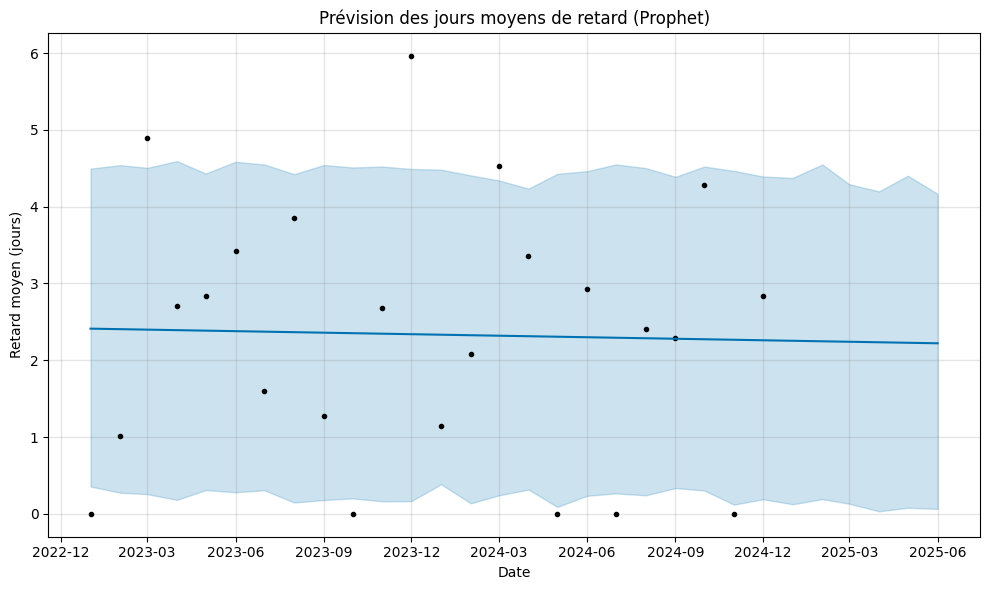

In [43]:
# Prophet Model
model_prophet = Prophet()
model_prophet.fit(ts_df)

# Predict 6 months into the future
future_prophet = model_prophet.make_future_dataframe(periods=6, freq='MS')
forecast_prophet = model_prophet.predict(future_prophet)

# Extract the forecasted values for comparison
y_pred_prophet = forecast_prophet['yhat'].values[-6:]  # Last 6 months (future predictions)
y_pred_lower_prophet = forecast_prophet['yhat_lower'].values[-6:]  # Lower confidence interval
y_pred_upper_prophet = forecast_prophet['yhat_upper'].values[-6:]  # Upper confidence interval

# Visualize Prophet forecast
fig = model_prophet.plot(forecast_prophet)
plt.title("Prévision des jours moyens de retard (Prophet)")
plt.xlabel("Date")
plt.ylabel("Retard moyen (jours)")
plt.tight_layout()
plt.show()

 Contexte du graphique :
Axe X = temps (mois, de 2023 à mi-2025)

Axe Y = retard moyen en jours (variable y)

Points noirs = observations réelles

Courbe bleue = prévision moyenne de Prophet

Zone bleue = intervalle de confiance (95%)

# ARIMA Model

C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


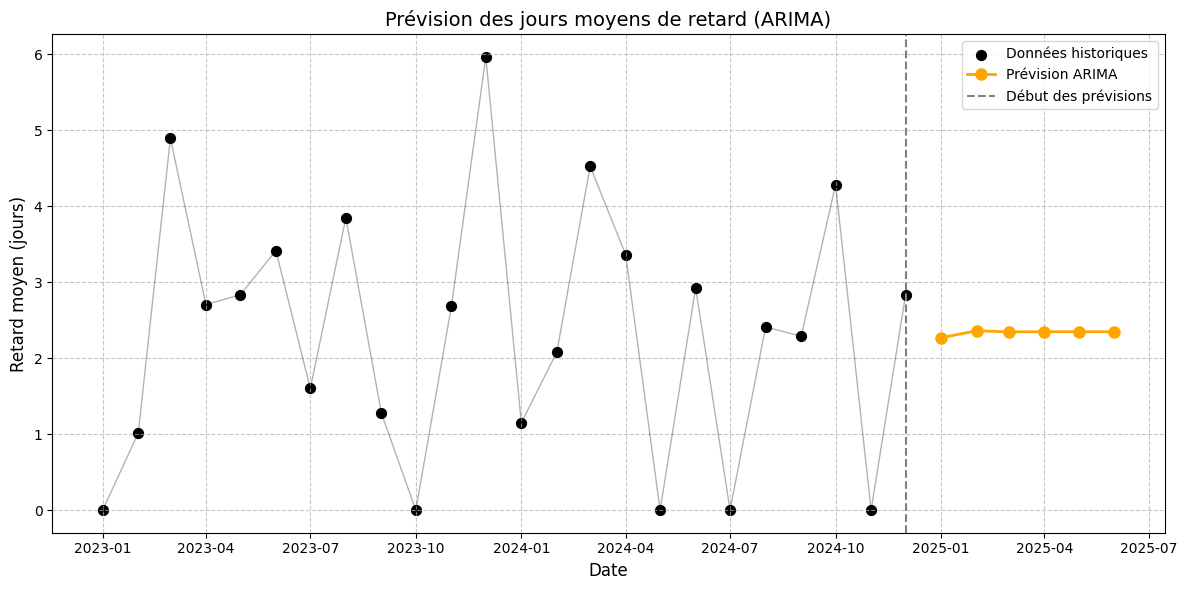

In [44]:
# ARIMA Model
# Fit ARIMA model (p=1, d=1, q=1)
model_arima = ARIMA(ts_series, order=(1, 1, 1))
arima_result = model_arima.fit()

# Forecast 6 months into the future
forecast_arima = arima_result.forecast(steps=6)
y_pred_arima = forecast_arima.values

# Combine historical and forecasted data for plotting
all_dates = list(ts_series.index) + list(future_dates)
all_values = list(ts_series.values) + list(y_pred_arima)

# Visualize ARIMA forecast
plt.figure(figsize=(12, 6))
# Historical data (black dots with faint line)
plt.scatter(ts_series.index, ts_series.values, color='black', label='Données historiques', s=50)
plt.plot(ts_series.index, ts_series.values, color='black', alpha=0.3, linestyle='-', linewidth=1)
# Forecast (orange line with markers)
plt.plot(future_dates, y_pred_arima, color='orange', label='Prévision ARIMA', linewidth=2, marker='o', markersize=8)
# Vertical line to separate historical and forecast periods
plt.axvline(x=ts_series.index[-1], color='gray', linestyle='--', label='Début des prévisions')
# Plot settings
plt.title("Prévision des jours moyens de retard (ARIMA)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Retard moyen (jours)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# SARIMA Model

C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\moham\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


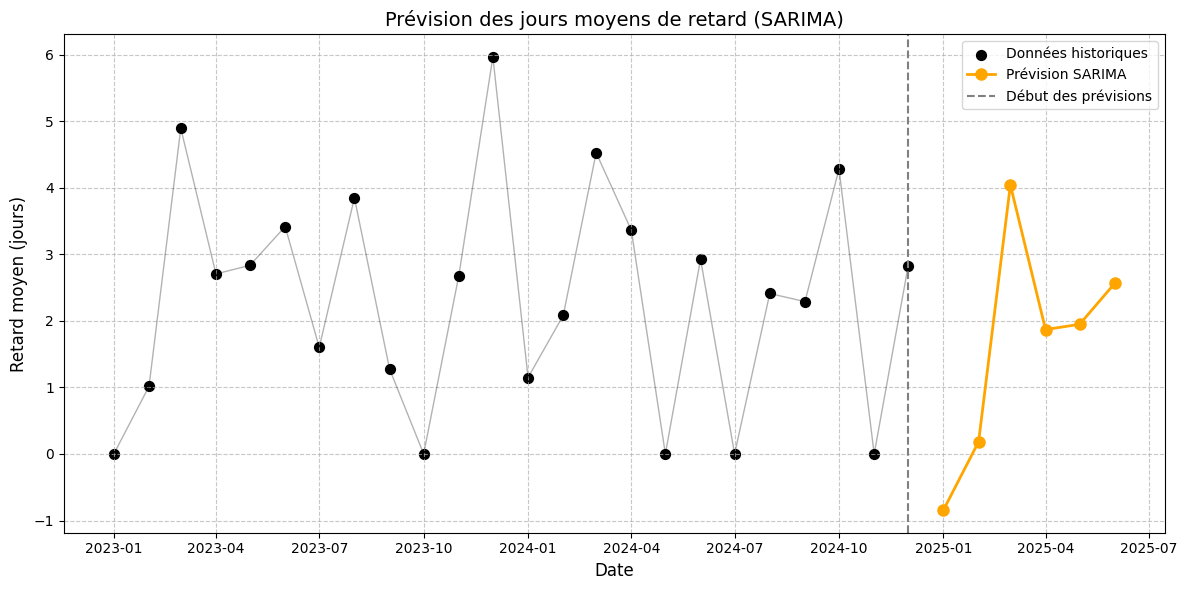

In [45]:
# SARIMA Model
# Fit SARIMA model (p=1, d=1, q=1) with seasonal order (P=1, D=1, Q=1, s=12 for yearly seasonality)
model_sarima = SARIMAX(ts_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = model_sarima.fit(disp=False)

# Forecast 6 months into the future
forecast_sarima = sarima_result.forecast(steps=6)
y_pred_sarima = forecast_sarima.values

# Combine historical and forecasted data for plotting
all_values_sarima = list(ts_series.values) + list(y_pred_sarima)

# Visualize SARIMA forecast
plt.figure(figsize=(12, 6))
# Historical data (black dots with faint line)
plt.scatter(ts_series.index, ts_series.values, color='black', label='Données historiques', s=50)
plt.plot(ts_series.index, ts_series.values, color='black', alpha=0.3, linestyle='-', linewidth=1)
# Forecast (orange line with markers)
plt.plot(future_dates, y_pred_sarima, color='orange', label='Prévision SARIMA', linewidth=2, marker='o', markersize=8)
# Vertical line to separate historical and forecast periods
plt.axvline(x=ts_series.index[-1], color='gray', linestyle='--', label='Début des prévisions')
# Plot settings
plt.title("Prévision des jours moyens de retard (SARIMA)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Retard moyen (jours)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comparison of Time Series Models

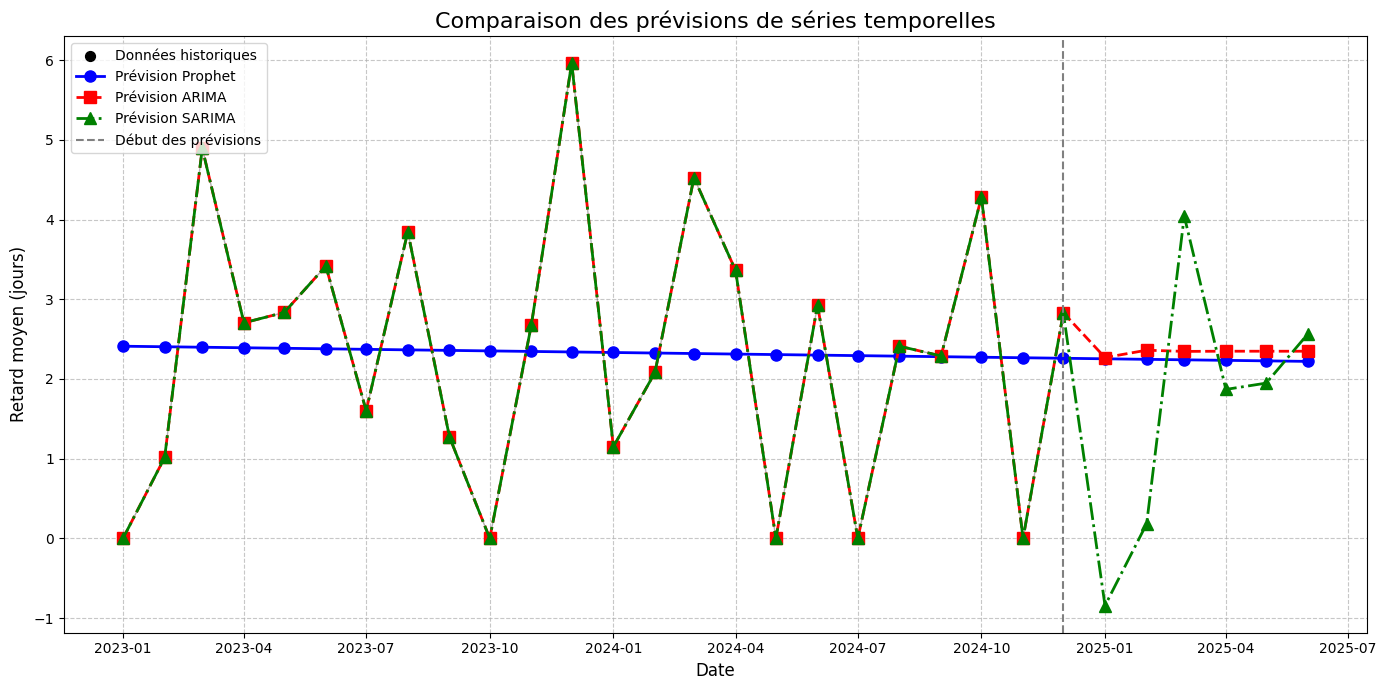


📊 Comparaison des modèles de séries temporelles (Visuelle):
          Method
Prophet  Prophet
ARIMA      ARIMA
SARIMA    SARIMA


In [46]:
# Combined plot for comparison
plt.figure(figsize=(14, 7))
# Historical data (black dots with faint line)
plt.scatter(ts_series.index, ts_series.values, color='black', label='Données historiques', s=50)
plt.plot(ts_series.index, ts_series.values, color='black', alpha=0.3, linestyle='-', linewidth=1)
# Prophet forecast (blue line with markers)
plt.plot(future_prophet['ds'], forecast_prophet['yhat'], color='blue', label='Prévision Prophet', linewidth=2, marker='o', markersize=8)
# ARIMA forecast (red dashed line with markers)
plt.plot(all_dates, all_values, color='red', label='Prévision ARIMA', linewidth=2, linestyle='--', marker='s', markersize=8)
# SARIMA forecast (green dash-dot line with markers)
plt.plot(all_dates, all_values_sarima, color='green', label='Prévision SARIMA', linewidth=2, linestyle='-.', marker='^', markersize=8)
# Vertical line to separate historical and forecast periods
plt.axvline(x=ts_series.index[-1], color='gray', linestyle='--', label='Début des prévisions')
# Plot settings
plt.title("Comparaison des prévisions de séries temporelles", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Retard moyen (jours)", fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Placeholder comparison table (since we don't have actual future data)
results_ts = {
    "Prophet": {"Method": "Prophet"},
    "ARIMA": {"Method": "ARIMA"},
    "SARIMA": {"Method": "SARIMA"}
}
print("\n📊 Comparaison des modèles de séries temporelles (Visuelle):")
comparison_df_ts = pd.DataFrame(results_ts).T
print(comparison_df_ts)

Prophet provides a stable forecast, smoothing out fluctuations.
ARIMA predicts a slight upward trend but lacks seasonality.
SARIMA captures both a trend and seasonal fluctuations, making it the most dynamic forecast.

SARIMA captures both the trend and potential seasonal patterns in your monthly delay data, as seen in the plot’s dynamic forecast (green dash-dot line), making it more suitable than Prophet’s flat prediction or ARIMA’s non-seasonal trend.


In [47]:
import joblib

# Save SARIMA model
joblib.dump(sarima_result, 'sarima_model.pkl')
print("SARIMA model saved as sarima_model.pkl")


SARIMA model saved as sarima_model.pkl


# Recomendation System

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Copy dataset
df_model = df.copy()

# Encode categorical values
le_supplier = LabelEncoder()
le_mp = LabelEncoder()

df_model['Supplier_ID_enc'] = le_supplier.fit_transform(df_model['supplier_id'])
df_model['MP_ID_enc'] = le_mp.fit_transform(df_model['mp_id'])

# Feature and target definition
features = ['Supplier_ID_enc', 'MP_ID_enc', 'supplier_avg_delay', 'Delay_Days', 'Price__USD_per_unit', 'IsLate']
target = 'AvgDelay_DelayDiff'  # Lower is better

X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Model
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict score for all supplier-MP pairs
df_model['Predicted_Score'] = model.predict(X)

# Recommend best supplier for each MP_ID
best_suppliers = df_model.sort_values(by='Predicted_Score').groupby('mp_id').first().reset_index()

# Show recommended supplier names
recommendations = best_suppliers[['Product_Name', 'Supplier_Name', 'Predicted_Score']]
print("\n🎯 Recommended Suppliers per Material:")
print(recommendations)
#Cos similarity


🎯 Recommended Suppliers per Material:
                           Product_Name         Supplier_Name  Predicted_Score
0                          72h Moisture     Extraits de Cèdre        -1.967496
1                        Abyssinian Oil  Essentiels du Sahara        -2.958120
2                        Acacia Extract     Mélanges Naturels        -1.986419
3                           Acacia Milk    Extraits Tunisiens        -2.985499
4                    Acai Fruit Extract       Parfums de Sfax        -1.958816
...                                 ...                   ...              ...
1098  Zein & Multi-Herb Extract Complex        Arômes Tunisie        -2.013985
1099             Zinc Oxide, Micronized     Extraits de Cèdre        -1.967496
1100    Zinc Oxide, Micronized & Coated       Parfums de Sfax        -1.958816
1101                    Zinc Oxide, USP  Aromatiques de Gabès        -1.924502
1102                   Zinc Ricinoleate     Extraits de Cèdre        -1.967496

[1103 rows x

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Use the same features or a subset for cosine similarity
cos_features = ['supplier_avg_delay', 'Delay_Days', 'Price__USD_per_unit', 'IsLate']
X_cos = df_model[cos_features]

# Scale the features so cosine similarity makes sense
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cos)

# Compute cosine similarity matrix (supplier-material to all others)
cos_sim_matrix = cosine_similarity(X_scaled)

# Build an "ideal" profile per material (lowest delay, best price etc.)
ideal_profiles = df_model.groupby('mp_id')[cos_features].mean()

# Normalize
ideal_scaled = scaler.transform(ideal_profiles)

# Compute cosine similarity between all rows and each ideal material profile
similarity_scores = cosine_similarity(X_scaled, ideal_scaled)

# Get the best supplier per material based on cosine similarity
best_indices = similarity_scores.argmax(axis=0)  # One best per mp_id
best_cosine_df = df_model.iloc[best_indices].copy()
best_cosine_df['Cosine_Similarity_Score'] = similarity_scores[best_indices, range(len(best_indices))]

# Final recommendations
recommendations_cosine = best_cosine_df[['Product_Name', 'Supplier_Name', 'Cosine_Similarity_Score']]
print("\n📌 Cosine Similarity Recommendations:")
print(recommendations_cosine)



📌 Cosine Similarity Recommendations:
                 Product_Name         Supplier_Name  Cosine_Similarity_Score
1362         Peach Kernel Oil  Essentiels du Sahara                 0.956649
1435         Peach Kernel Oil  Essentiels du Sahara                 0.907806
1379    Sea Buckthorn Extract  Essentiels du Sahara                 0.931092
1362         Peach Kernel Oil  Essentiels du Sahara                 0.975159
1452    Sea Buckthorn Extract  Essentiels du Sahara                 0.931830
...                       ...                   ...                      ...
116            Mica Sand Gold    Extraits Tunisiens                 0.996079
1325  Carob Tree Gum & Casein  Essentiels du Sahara                 0.954872
1435         Peach Kernel Oil  Essentiels du Sahara                 0.910537
8756              Soybean Oil          Parfums Purs                 0.793140
1366     Pentylene Glycol BIO  Essentiels du Sahara                 0.956177

[1103 rows x 3 columns]
